In [1]:
import os
import glob
import numpy as np
import tree
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import seaborn as sns
%matplotlib inline

In [5]:
def format_column(df):
  # reformat column names
  columns = list(map(lambda name: name[1:] if name[0] == ' ' else name, df.columns.tolist()))
  columns = list(map(lambda name: name[:-1] if name[-1] == ' ' else name, columns))
  df.columns = columns
  df['Survey ID'] = df['Q2 (Please enter your survey reference number (leave blank if you do not have a reference number).)']
  return df

# load obg
dir_path = '../data/FOI_consultation/'
df_obg_1 = pd.read_csv(dir_path + 'FOI_OBG.csv')
df_obg_1 = format_column(df_obg_1)
df_obg_1['location'] = 'obg'
df_obg_2 = pd.read_csv(dir_path + 'FOI_OBG_2.csv')
df_obg_2 = format_column(df_obg_2)
df_obg_2['location'] = 'obg'

rows_kept_in_v2 = df_obg_1['Response ID'].isin(df_obg_2['Response ID'])
df_obg_2['Survey ID'] = df_obg_1['Survey ID'][rows_kept_in_v2]
df_obg_excluded = df_obg_1[~rows_kept_in_v2]

# load weavers
df_weavers_1 = pd.read_csv(dir_path + 'FOI_WEAVERS.csv')
df_weavers_1 = format_column(df_weavers_1)
df_weavers_1['location'] = 'weavers'
df_weavers_2 = pd.read_csv(dir_path + 'FOI_WEAVERS_2.csv')
df_weavers_2 = format_column(df_weavers_2)
df_weavers_2['location'] = 'weavers'

rows_kept_in_v2 = df_weavers_1['Response ID'].isin(df_weavers_2['Response ID'])
df_weavers_2['Survey ID'] = df_weavers_1['Survey ID'][rows_kept_in_v2]
df_weavers_excluded = df_weavers_1[~rows_kept_in_v2]


# concat
df = pd.concat([df_obg_2, df_weavers_2])
df_excluded = pd.concat([df_obg_excluded, df_weavers_excluded])

3747
893
2854
3747
{1: 893, 2: 2854, 0: 0.0, 3: 0.0}
1890
1310
543
1853
{0: 42, 1: 1305, 2: 538, 3: 5}


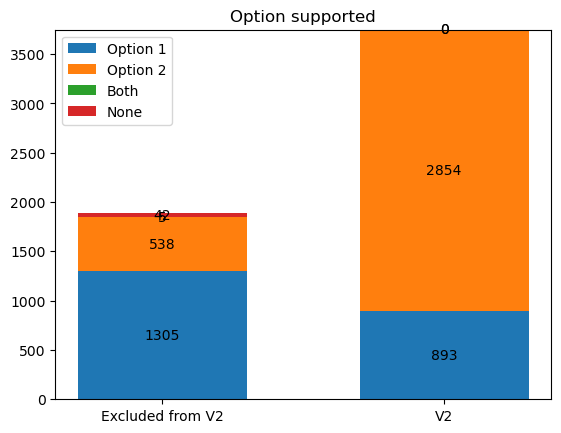

In [6]:
# check stats of excluded answers
list(df.columns)
col_opt1 = 'Q4 (Which option do you support?) I support Option 1 to remove the Liveable Streets closures and make public realm improvements to the wider area.'
col_opt2 = 'Q4 (Which option do you support?) I support Option 2 to retain the existing traffic arrangements'
print(len(df))
print(df[col_opt1].sum())
print(df[col_opt2].sum())
print(df[col_opt1].sum() + df[col_opt2].sum())
col_opt = 1 * df[col_opt1] + 2 * df[col_opt2]
counter = Counter(col_opt)
counter = dict(sorted(counter.items(), key=lambda item: item[0]))
for i in range(4):
  if i not in counter.keys():
    counter[i] = 0.
print(counter)

df_excluded
print(len(df_excluded))
print(df_excluded[col_opt1].sum())
print(df_excluded[col_opt2].sum())
print(df_excluded[col_opt1].sum() + df_excluded[col_opt2].sum())
col_opt = 1 * df_excluded[col_opt1] + 2 * df_excluded[col_opt2]
counter_excluded = Counter(col_opt)
counter_excluded = dict(sorted(counter_excluded.items(), key=lambda item: item[0]))
for i in range(4):
  if i not in counter_excluded.keys():
    counter_excluded[i] = 0.
print(counter_excluded)


species = ('Excluded from V2', 'V2')
sex_counts = {
    'Option 1': np.array([counter_excluded[1], counter[1]]),
    'Option 2': np.array([counter_excluded[2], counter[2]]),
    'Both': np.array([counter_excluded[3], counter[3]]),
    'None': np.array([counter_excluded[0], counter[0]]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
bottom = np.zeros(2)

for sex, sex_count in sex_counts.items():
    p = ax.bar(species, sex_count, width, label=sex, bottom=bottom)
    bottom += sex_count

    ax.bar_label(p, label_type='center')

ax.set_title('Option supported')
ax.legend()

plt.show()

In [7]:
# whether people filled in the form with survey reference number of not
ref_col = df['Survey ID']
# print(list(ref_col.unique()))
# has_reference = ~(ref_col.isna() | ref_col.isin(['Section 40 FOIA', 'FOIA', 'none', np.nan, 'Never sent', 'Lost it :(']))
has_reference = ~ref_col.isna()
df['has_reference'] = has_reference

In [8]:
# different means of transportation considered in the survey
modes_of_transport = [
    'Car/van driver',
    'Car/van passenger',
    'Public transport (bus/Tube/train)',
    'Cycle',
    'Walk – most or all of the way',
    'No journey - telework or work from home',
]
question_str = 'Q21 (For each mode of transport used to travel to work, have you reduced or increased the use youmake of it compared with before the liveable streets scheme was implemented?) '
columns = [question_str + mode for mode in modes_of_transport]
answers = ['No answer', 'Increased a lot', 'Increased a little', 'No change', 'Reduced a little', 'Reduced a lot', 'N/A'] #cf 'Codification key' table, with added  'No answer' for 0

In [9]:
def make_plot(cols, columns, answers, modes_of_transport):
  location = cols['location'].unique()[0].upper()

  M = len(columns)
  width = 0.2
  # colors = sns.color_palette("vlag", 5)
  # colors = sns.diverging_palette(150, 10, n=5)
  colors = list(reversed(plt.colormaps['RdYlGn'](np.linspace(0.15, 0.85, 5))))
  colors += [(.5, .5, .5, 1.), (.5, .5, .5, 1.)]

  fig, axs = plt.subplots(M, 1, figsize=(10, M*2), sharex=False, sharey='col')
  for i, column, mode_of_transport in zip(range(M), columns, modes_of_transport):

    # all
    data = cols[column]
    N = len(data)
    counter = Counter(data)
    counter = dict(sorted(counter.items(), key=lambda item: item[0]))
    # print(counter)
    keys = list(counter.keys())
    assert sorted(keys) == list(range(7))
    values = list(counter.values())
    values = list(np.array(values) / sum(values) * 100)
    # print(values, sum(values))
    idx = np.asarray([i for i in range(len(keys))])
    bars = axs[i].bar(idx, values[1:] + values[0:1], width=width, color=colors, label='all respondant')
    axs[i].bar_label(bars, fmt="%.1f")

    # filtering ones with reference code
    data = data[cols['has_reference'] == True]
    counter = Counter(data)
    counter = dict(sorted(counter.items(), key=lambda item: item[0]))
    # print(counter)
    keys = list(counter.keys())
    assert list(sorted(keys)) == list(range(7))
    values = list(counter.values())
    values = list(np.array(values) / sum(values) * 100)
    # print(values, sum(values))
    idx = np.asarray([i for i in range(len(keys))])
    bars = axs[i].bar(idx+width, values[1:] + values[0:1], color=colors, width=width, hatch='x', label='with reference code')
    axs[i].bar_label(bars, fmt="%.1f")

    axs[i].set_title(mode_of_transport)
    axs[i].set_xticks(idx)
    axs[i].set_xticklabels(answers[1:] + answers[0:1], rotation=0)
    axs[i].legend(loc='upper center')
    # axs[i].set_xlabel('')
    axs[i].set_ylabel('% of answers')

  fig.suptitle(location)
  fig.subplots_adjust(top=0.88)
  fig.tight_layout()

In [10]:
def make_plot_2(cols, columns, answers, modes_of_transport):
  location = cols['location'].unique()[0].upper()
  categories = ['All respondant', 'With reference code']
  # categories = ['All respondant']

  M = len(columns)
  width = 0.2
  # colors = sns.color_palette("vlag", 5)
  colors = sns.diverging_palette(150, 10, n=5)
  colors = list(reversed(plt.colormaps['RdYlGn'](np.linspace(0.15, 0.85, 5))))
  colors += [(.5, .5, .5, 1.), (.5, .5, .5, 1.)]

  fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

  print('columns', columns)
  print('answers', answers)
  print('modes_of_transport', modes_of_transport)

  for k, (ax, category) in enumerate(zip(axs, categories)):
    data = np.zeros((6, 7)) # modes of transports x levels of change in use
    if category == 'With reference code':
      cols = cols[cols['has_reference'] == True]
    for j, col in enumerate(cols[columns].values.T):
      counter = Counter(col) # Count how many times each level (of change of use) has appeared in the answers
      for i in range(7):
        if i not in counter:
          counter[i] = 0
      counter = dict(sorted(counter.items(), key=lambda item: item[0])) # sort levels as 0, 1, 2, 3, 4, 5, 6
      print('counter', counter)
      keys = list(counter.keys())
      assert keys == list(range(7)) # check there are 7 levels of answers
      values = list(counter.values())
      # print('values', values)
      data[j, :] = values # set for jth mode of transport change in use

    # Remove 'no answer'
    # answers = answers[1:]
    # data[:, 1:]
    # Shift 'no answer' at the end

    answers = answers[1:] + answers[0:1]
    data = np.concatenate([data[:, 1:], data[:, 0:1]], -1)
    data_cum = data.cumsum(axis=1)
    print('data', data)
    print('answers', answers)


    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(answers, colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(modes_of_transport, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color, fmt="%.0f")
    rect = ax.patches[-1]
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    # print(rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height())

    # check we have the same number of answers for each mode of transport
    tot_mode = None
    for j, mode in enumerate(modes_of_transport):
      if tot_mode is not None:
        assert int(sum(data[j])) == tot_mode
      tot_mode = int(sum(data[j]))
      print(mode, tot_mode)
    if k == 0:
      ax.legend(ncols=len(answers), bbox_to_anchor=(0, -.1), loc='lower left', fontsize='small')
    ax.set_title(category)

  fig.suptitle(location)
  fig.subplots_adjust(top=0.88)
  # fig.tight_layout()

columns ['Q21 (For each mode of transport used to travel to work, have you reduced or increased the use youmake of it compared with before the liveable streets scheme was implemented?) Car/van driver', 'Q21 (For each mode of transport used to travel to work, have you reduced or increased the use youmake of it compared with before the liveable streets scheme was implemented?) Car/van passenger', 'Q21 (For each mode of transport used to travel to work, have you reduced or increased the use youmake of it compared with before the liveable streets scheme was implemented?) Public transport (bus/Tube/train)', 'Q21 (For each mode of transport used to travel to work, have you reduced or increased the use youmake of it compared with before the liveable streets scheme was implemented?) Cycle', 'Q21 (For each mode of transport used to travel to work, have you reduced or increased the use youmake of it compared with before the liveable streets scheme was implemented?) Walk – most or all of the way'

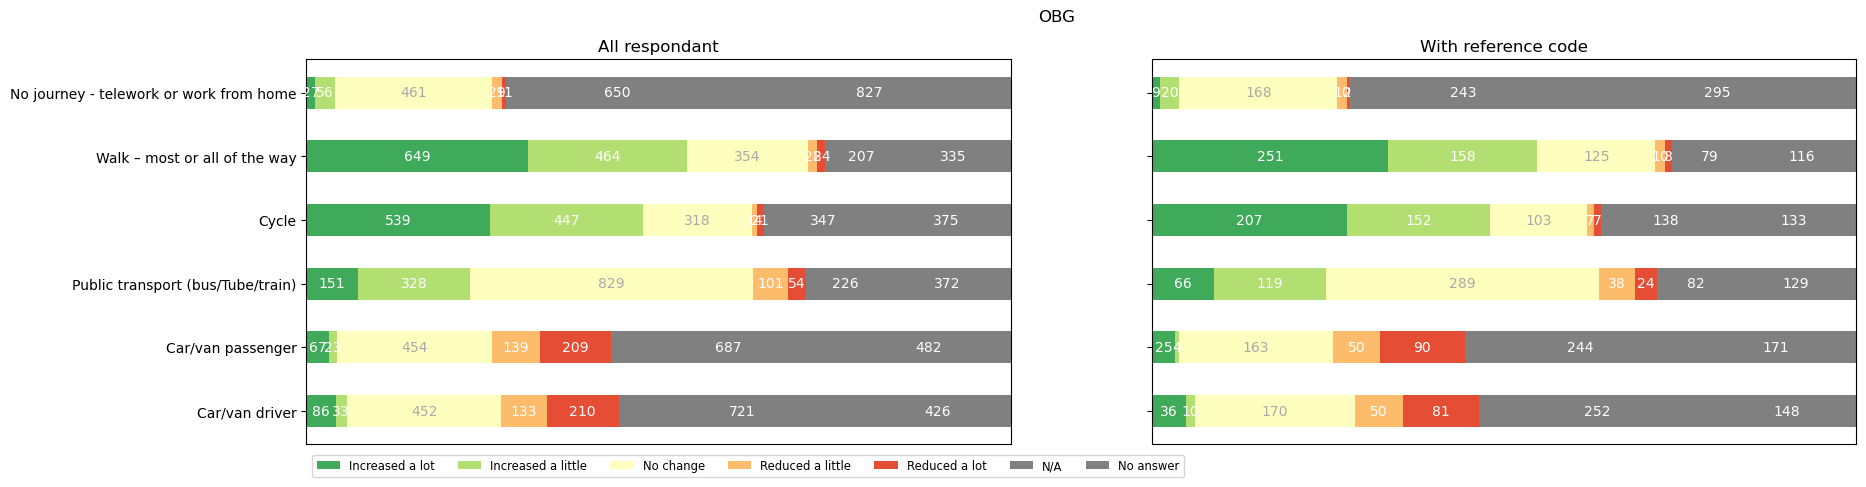

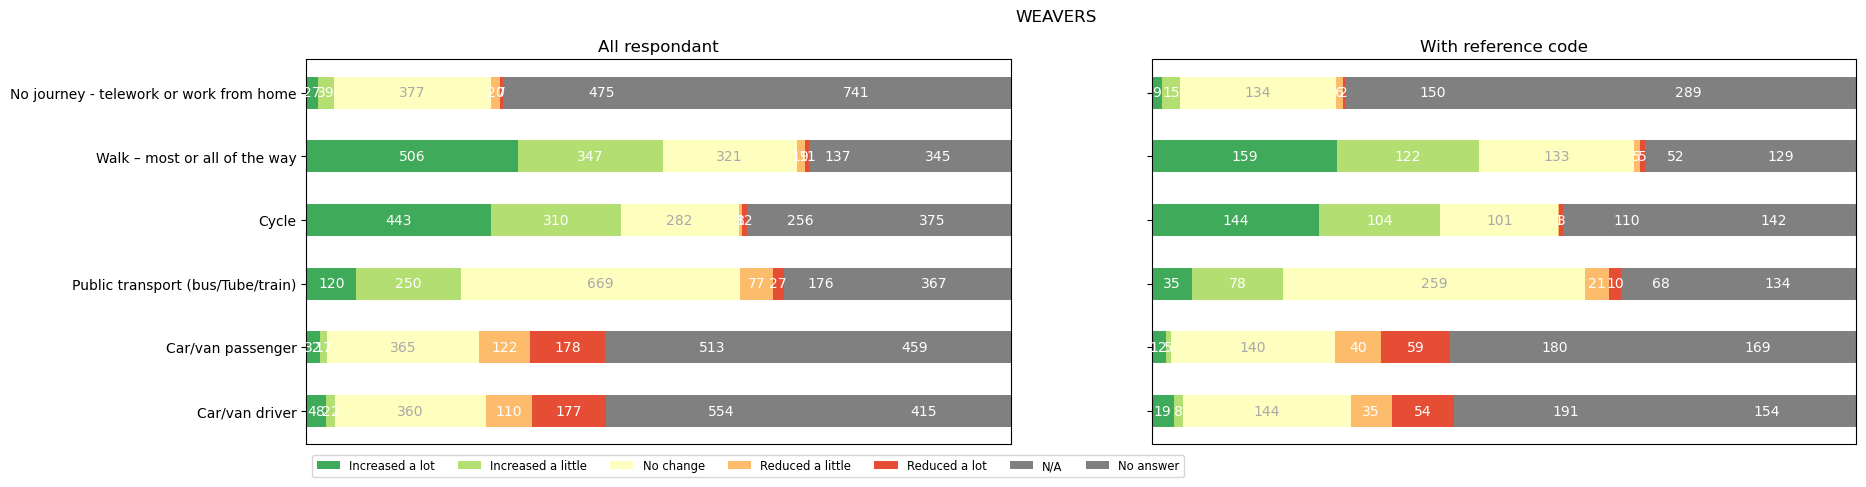

In [11]:
cols = df[['has_reference', 'location'] + columns]

cols_obg = cols[cols['location'] == 'obg']
make_plot_2(cols_obg, columns, answers, modes_of_transport)

cols_weavers = cols[cols['location'] == 'weavers']
make_plot_2(cols_weavers, columns, answers, modes_of_transport)